In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import optimizers
import time

plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return numpy.array(dataX), numpy.array(dataY)

In [3]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [5]:
# load the dataset
dataframe = read_csv('clean_train_data.csv',header=0,squeeze=True)

In [6]:
import pandas as pd
# 日期格式转换函数
def convert_to_date(s):
    d = pd.to_datetime(s, format='%Y-%m-%d')
    return d

dataframe['Date'] = dataframe['Date'].apply(convert_to_date)
dataframe.index = dataframe['Date']
raw_dataframe = dataframe.copy()

# 2005-01 2016-12 2017-09
start_date = pd.to_datetime('2005-01')
end_date = pd.to_datetime('2017-09')
mask = (dataframe['Date'] > start_date) & (dataframe['Date'] <= end_date)
dataframe = dataframe.loc[mask]
dataframe = dataframe['Num']

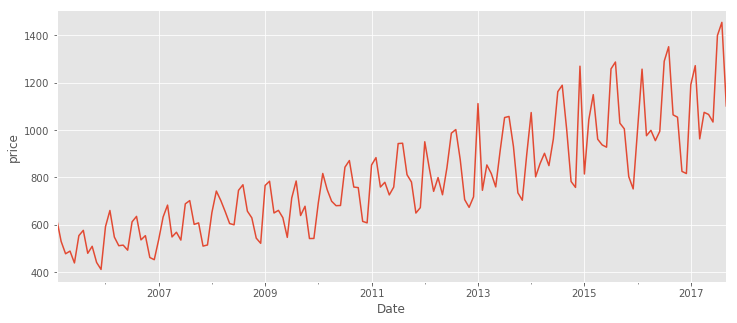

In [7]:
plt.figure(figsize=(12,5))
dataframe.plot()
plt.ylabel('price')
plt.show()

In [8]:
dataset = dataframe.values
dataset

array([  623.19,   528.91,   476.69,   487.96,   437.93,   553.32,
         575.57,   478.67,   508.2 ,   439.97,   410.44,   591.1 ,
         659.53,   547.35,   510.72,   513.07,   491.84,   611.56,
         634.61,   535.25,   553.23,   460.84,   451.68,   536.5 ,
         632.24,   682.21,   547.72,   567.59,   534.41,   687.58,
         701.31,   600.76,   607.13,   509.07,   513.75,   650.91,
         741.6 ,   701.88,   654.67,   604.36,   598.93,   744.62,
         768.2 ,   656.67,   628.38,   542.65,   520.86,   765.27,
         782.94,   649.  ,   660.06,   629.04,   545.83,   712.14,
         784.11,   638.15,   677.37,   541.04,   541.34,   692.32,
         815.83,   747.18,   698.56,   679.83,   680.58,   842.27,
         870.45,   758.49,   756.16,   613.46,   607.17,   851.58,
         882.77,   758.55,   778.66,   725.3 ,   758.34,   942.22,
         943.63,   810.56,   779.8 ,   648.66,   671.55,   949.78,
         840.49,   740.33,   798.49,   725.89,   839.92,   986

In [9]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

/home/shensir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/shensir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [39]:
# split into train and test sets
train_size = int(len(dataset) * 0.965)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

In [40]:
train.shape

(146,)

In [41]:
test.shape

(6,)

In [42]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [43]:
trainX

array([[ 0.20383038],
       [ 0.1135031 ],
       [ 0.06347245],
       [ 0.07426995],
       [ 0.02633747],
       [ 0.13688971],
       [ 0.15820687],
       [ 0.06536943],
       [ 0.09366138],
       [ 0.02829194],
       [ 0.        ],
       [ 0.17308577],
       [ 0.23864682],
       [ 0.13117   ],
       [ 0.09607573],
       [ 0.0983272 ],
       [ 0.07798728],
       [ 0.19268797],
       [ 0.2147716 ],
       [ 0.1195773 ],
       [ 0.13680348],
       [ 0.04828696],
       [ 0.039511  ],
       [ 0.12077489],
       [ 0.21250096],
       [ 0.26037595],
       [ 0.13152449],
       [ 0.15056143],
       [ 0.11877251],
       [ 0.26552081],
       [ 0.27867517],
       [ 0.18234077],
       [ 0.1884437 ],
       [ 0.0944949 ],
       [ 0.09897869],
       [ 0.23038821],
       [ 0.317276  ],
       [ 0.27922128],
       [ 0.23399057],
       [ 0.18578984],
       [ 0.18058749],
       [ 0.32016939],
       [ 0.34276079],
       [ 0.23590672],
       [ 0.20880279],
       [ 0

In [44]:
trainY

array([ 0.1135031 ,  0.06347245,  0.07426995,  0.02633747,  0.13688971,
        0.15820687,  0.06536943,  0.09366138,  0.02829194,  0.        ,
        0.17308577,  0.23864682,  0.13117   ,  0.09607573,  0.0983272 ,
        0.07798728,  0.19268797,  0.2147716 ,  0.1195773 ,  0.13680348,
        0.04828696,  0.039511  ,  0.12077489,  0.21250096,  0.26037595,
        0.13152449,  0.15056143,  0.11877251,  0.26552081,  0.27867517,
        0.18234077,  0.1884437 ,  0.0944949 ,  0.09897869,  0.23038821,
        0.317276  ,  0.27922128,  0.23399057,  0.18578984,  0.18058749,
        0.32016939,  0.34276079,  0.23590672,  0.20880279,  0.12666705,
        0.1057906 ,  0.33995363,  0.35688281,  0.22855829,  0.23915459,
        0.20943512,  0.12971373,  0.28905112,  0.35800376,  0.21816318,
        0.25573887,  0.12512455,  0.12541197,  0.27006208,  0.38839388,
        0.32262206,  0.27604047,  0.25809573,  0.25881429,  0.41372538,
        0.44072392,  0.33345788,  0.33122557,  0.19450832,  0.18

In [45]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [46]:
trainX

array([[[ 0.20383038]],

       [[ 0.1135031 ]],

       [[ 0.06347245]],

       [[ 0.07426995]],

       [[ 0.02633747]],

       [[ 0.13688971]],

       [[ 0.15820687]],

       [[ 0.06536943]],

       [[ 0.09366138]],

       [[ 0.02829194]],

       [[ 0.        ]],

       [[ 0.17308577]],

       [[ 0.23864682]],

       [[ 0.13117   ]],

       [[ 0.09607573]],

       [[ 0.0983272 ]],

       [[ 0.07798728]],

       [[ 0.19268797]],

       [[ 0.2147716 ]],

       [[ 0.1195773 ]],

       [[ 0.13680348]],

       [[ 0.04828696]],

       [[ 0.039511  ]],

       [[ 0.12077489]],

       [[ 0.21250096]],

       [[ 0.26037595]],

       [[ 0.13152449]],

       [[ 0.15056143]],

       [[ 0.11877251]],

       [[ 0.26552081]],

       [[ 0.27867517]],

       [[ 0.18234077]],

       [[ 0.1884437 ]],

       [[ 0.0944949 ]],

       [[ 0.09897869]],

       [[ 0.23038821]],

       [[ 0.317276  ]],

       [[ 0.27922128]],

       [[ 0.23399057]],

       [[ 0.18578984]],



In [47]:
# create and fit the LSTM network
model = Sequential()

model.add(LSTM(input_dim=1,output_dim=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(output_dim=1))
model.add(Activation('linear'))

start=time.time()
model.compile(loss='mean_squared_error',optimizer='Adam')
print ('compilation time:',time.time()-start)

history=model.fit(trainX,trainY,batch_size=1,nb_epoch=30,validation_split=0.2,verbose=2)

/home/shensir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  after removing the cwd from sys.path.
/home/shensir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
  after removing the cwd from sys.path.
/home/shensir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  # Remove the CWD from sys.path while we load stuff.
/home/shensir/anaconda3/lib/python3.6/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


compilation time: 0.041298866271972656
Train on 115 samples, validate on 29 samples
Epoch 1/30
3s - loss: 0.0327 - val_loss: 0.0662
Epoch 2/30
0s - loss: 0.0162 - val_loss: 0.0562
Epoch 3/30
0s - loss: 0.0134 - val_loss: 0.0658
Epoch 4/30
0s - loss: 0.0128 - val_loss: 0.0576
Epoch 5/30
0s - loss: 0.0134 - val_loss: 0.0422
Epoch 6/30
0s - loss: 0.0118 - val_loss: 0.0647
Epoch 7/30
0s - loss: 0.0125 - val_loss: 0.0432
Epoch 8/30
0s - loss: 0.0128 - val_loss: 0.0447
Epoch 9/30
0s - loss: 0.0124 - val_loss: 0.0412
Epoch 10/30
0s - loss: 0.0122 - val_loss: 0.0419
Epoch 11/30
0s - loss: 0.0118 - val_loss: 0.0403
Epoch 12/30
0s - loss: 0.0123 - val_loss: 0.0398
Epoch 13/30
0s - loss: 0.0126 - val_loss: 0.0517
Epoch 14/30
0s - loss: 0.0133 - val_loss: 0.0482
Epoch 15/30
0s - loss: 0.0129 - val_loss: 0.0441
Epoch 16/30
0s - loss: 0.0119 - val_loss: 0.0403
Epoch 17/30
0s - loss: 0.0122 - val_loss: 0.0403
Epoch 18/30
0s - loss: 0.0127 - val_loss: 0.0470
Epoch 19/30
0s - loss: 0.0135 - val_loss: 0

In [48]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [49]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [50]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 136.28 RMSE
Test Score: 223.14 RMSE


In [51]:
# shift train predictions for plotting
trainPredictPlot=numpy.empty_like(dataset)
trainPredictPlot[:]=numpy.nan
trainPredictPlot=numpy.reshape(trainPredictPlot,(dataset.shape[0],1))
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [52]:
# shift test predictions for plotting
testPredictPlot=numpy.empty_like(dataset)
testPredictPlot[:]=numpy.nan
testPredictPlot=numpy.reshape(testPredictPlot,(dataset.shape[0],1))
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

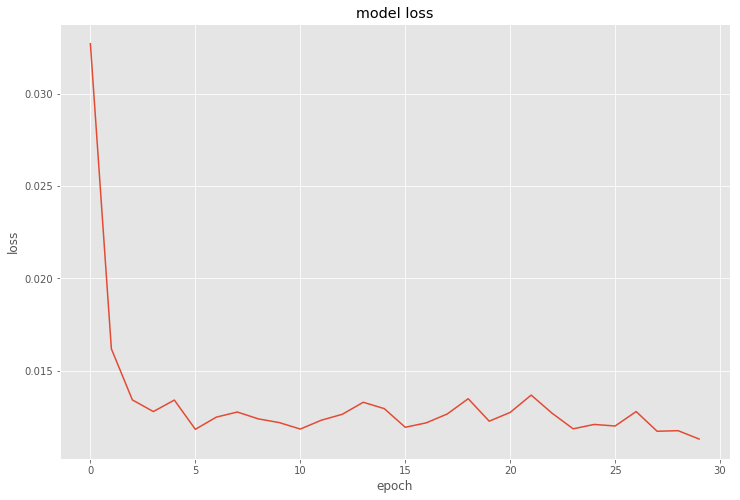

In [53]:
#summarize history for loss
fig=plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

/home/shensir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


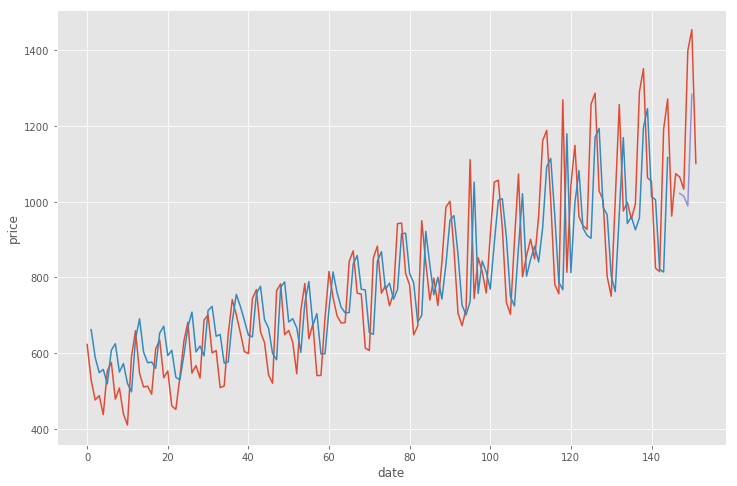

In [54]:
#plot predictions
fig=plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.ylabel('price')
plt.xlabel('date')
plt.show()

In [55]:
# 单独观察预测部分
Pred = testPredict[:,0]
Real = testY[0]

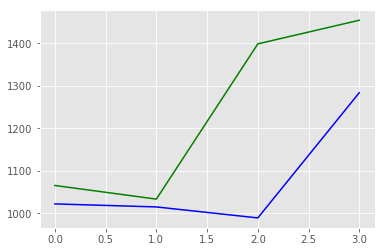

In [56]:
plt.plot(Pred, 'b')
plt.plot(Real, 'g')
plt.show()